## Functions and Classes

In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import norm
import matplotlib.pyplot as plt

# Class to represent a cylinder in 3D space
class Cylinder:
    def __init__(self, radius_lower, coordinates_lower, radius_upper, coordinates_upper, color, wall_lower, wall_upper):
        # Initialize the cylinder with its properties
        self.radius_lower = radius_lower  # Radius at the lower part of the cylinder
        self.coordinates_lower = np.array([coordinates_lower[0], coordinates_lower[1], wall_lower])  # Lower circle coordinates
        self.radius_upper = radius_upper  # Radius at the upper part of the cylinder
        self.coordinates_upper = np.array([coordinates_upper[0], coordinates_upper[1], wall_upper])  # Upper circle coordinates
        self.color = color  # Color for visualization

    def plot(self, fig):
        # Plot the cylinder in 3D by plotting two circles (upper and lower) and connecting them with lines
        theta = np.linspace(0, 2 * np.pi, 50)  # Angle values to plot the circles

        # Lower circle coordinates
        lower_circle_x = self.radius_lower * np.cos(theta) + self.coordinates_lower[0]
        lower_circle_y = self.radius_lower * np.sin(theta) + self.coordinates_lower[1]
        lower_circle_z = np.full_like(lower_circle_x, self.coordinates_lower[2])

        # Upper circle coordinates
        upper_circle_x = self.radius_upper * np.cos(theta) + self.coordinates_upper[0]
        upper_circle_y = self.radius_upper * np.sin(theta) + self.coordinates_upper[1]
        upper_circle_z = np.full_like(upper_circle_x, self.coordinates_upper[2])

        # Plot both circles (lower and upper)
        fig.add_trace(go.Scatter3d(x=lower_circle_x, y=lower_circle_y, z=lower_circle_z,
                                   mode='lines', line=dict(color=self.color, width=3),
                                   showlegend=False))
        fig.add_trace(go.Scatter3d(x=upper_circle_x, y=upper_circle_y, z=upper_circle_z,
                                   mode='lines', line=dict(color=self.color, width=3),
                                   showlegend=False))

        # Plot lines connecting corresponding points of the lower and upper circles
        for i in range(len(theta)):
            fig.add_trace(go.Scatter3d(x=[lower_circle_x[i], upper_circle_x[i]],
                                       y=[lower_circle_y[i], upper_circle_y[i]],
                                       z=[lower_circle_z[i], upper_circle_z[i]],
                                       mode='lines', line=dict(color=self.color, width=3),
                                       showlegend=False))

    def passes_through(self, start, direction):
        # Check if a particle passes through the cylinder by checking if it intersects both the upper and lower circles
        intersects_lower, _ = check_line_circle_intersection(
            start[0], start[1], start[2], direction[0], direction[1], direction[2],
            self.coordinates_lower[0], self.coordinates_lower[1], self.radius_lower, self.coordinates_lower[2])
        
        intersects_upper, _ = check_line_circle_intersection(
            start[0], start[1], start[2], direction[0], direction[1], direction[2],
            self.coordinates_upper[0], self.coordinates_upper[1], self.radius_upper, self.coordinates_upper[2])
        
        # Return True if the particle intersects both the lower and upper circles
        return intersects_lower and intersects_upper


# Function to check intersection of a line with a circle in 3D space
def check_line_circle_intersection(x0, y0, z0, dx, dy, dz, xc, yc, r, z1):

    # The line is given by the parametric equations:
    #   x = x0 + t * dx
    #   y = y0 + t * dy
    #   z = z0 + t * dz
    # where (x0, y0, z0) is a point on the line and (dx, dy, dz) is the direction vector.
    #
    # The circle is centered at (xc, yc) with radius r, and lies in the plane z = z1.
    #
    # Steps performed by the function:
    # 1. Calculate the parameter t at which the line intersects the plane z = z1 using:
    #    t = (z1 - z0) / dz
    #    This gives the intersection point (x_int, y_int) on the plane z = z1 as:
    #    x_int = x0 + t * dx
    #    y_int = y0 + t * dy
    #
    # 2. Compute the distance d from the circle's center (xc, yc) to the intersection point (x_int, y_int) using:
    #    d = sqrt((x_int - xc)^2 + (y_int - yc)^2)
    #
    # 3. Check if this distance d is less than or equal to the circle's radius r. If it is:
    #    - The line intersects or is inside the circle at the plane z = z1.
    #    - Return True and the coordinates of the intersection point (x_int, y_int, z1).
    # Otherwise:
    #    - The line does not intersect the circle at the plane.
    #    - Return False and None.
    
    if dz == 0:
        return False, None  # If dz = 0, the line is parallel to the z-plane and does not intersect
    
    # Calculate the parameter t where the line intersects the plane z = z1
    t = (z1 - z0) / dz
    x_int = x0 + t * dx  # Intersection x-coordinate
    y_int = y0 + t * dy  # Intersection y-coordinate
    
    # Compute distance from circle center to the intersection point
    d = np.sqrt((x_int - xc) ** 2 + (y_int - yc) ** 2)
    
    # If the distance is less than or equal to the radius, there is an intersection
    if d <= r:
        return True, (x_int, y_int, z1)
    else:
        return False, None

# Function to generate a random direction vector (unit vector)
def random_direction():
    # Randomly generate a direction on the unit sphere
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.arccos(np.random.uniform(-1, 1))
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return np.array([x, y, z])

# Function to generate a random point inside a circle at a given z-coordinate
def random_point_in_circle(radius, source_z):
    r = np.sqrt(np.random.uniform(0, 1)) * radius  # Random radial distance within the circle
    angle = np.random.uniform(0, 2 * np.pi)  # Random angle in the xy-plane
    x = r * np.cos(angle)
    y = r * np.sin(angle)
    return np.array([x, y, source_z])

# Function to generate paths for multiple particles
def generate_paths(num_particles, circle_radius, source_z, cylinders, chip_z):
    # Generate paths for a given number of particles starting from the source circle
    
    x_paths = []
    y_paths = []
    z_paths = []

    for _ in range(num_particles):
        direction = random_direction()  # Random direction for each particle
        # Calculate the path of the particle
        x_path, y_path, z_path = calculate_particle_path(source_z, direction, cylinders, chip_z, np.abs(source_z)/2, circle_radius)
        
        x_paths.append(x_path)
        y_paths.append(y_path)
        z_paths.append(z_path)
    
    return x_paths, y_paths, z_paths

# Function to add a plane (wall or chip) to the plot
def add_plane(fig, z_position, plane_width, plane_length, color='black', name="Package wall"):
    # Adds a 3D plane to the figure
    half_width = plane_width / 2
    half_length = plane_length / 2
    plane_x = np.array([-half_width, half_width, half_width, -half_width, -half_width])
    plane_y = np.array([-half_length, -half_length, half_length, half_length, -half_length])
    plane_z = np.full_like(plane_x, z_position)  # Constant z-coordinate for the plane
    
    fig.add_trace(go.Scatter3d(x=plane_x, y=plane_y, z=plane_z,
                               mode='lines', line=dict(color=color, width=2),
                               name=f'{name} at z={z_position}'))

# Function to add a circular source to the plot
def add_circle_source(fig, source_z, radius):
    # Adds a circle at the source z-coordinate to the plot
    theta = np.linspace(0, 2 * np.pi, 100)
    circle_x = radius * np.cos(theta)
    circle_y = radius * np.sin(theta)
    circle_z = np.full_like(circle_x, source_z)  # Fixed z-coordinate for the source
    
    fig.add_trace(go.Scatter3d(x=circle_x, y=circle_y, z=circle_z,
                               mode='lines', line=dict(color='red', width=2),
                               name=f'Source Circle at z={source_z} and radius {radius}'))

# Function to calculate the path of a particle based on its initial position and direction
def calculate_particle_path(source_z, direction, cylinders, chip_z, path_len, radius):
    # Initialize the source position as a random point in the source circle
    source_position = random_point_in_circle(radius, source_z)
    end_point = source_position + path_len * direction  # Calculate the end point of the path

    for cylinder in cylinders:
        # Check if the particle passes through the cylinder
        if cylinder.passes_through(source_position, direction):
            # If it intersects, calculate where the particle hits the chip (z = chip_z)
            t = (chip_z - source_position[2]) / direction[2]  # Solve for t to get the z = chip_z
            end_point = source_position + t * direction
            break

    # Return the path (from source to end point)
    return [source_position[0], end_point[0]], [source_position[1], end_point[1]], [source_position[2], end_point[2]]

# Function to check if the particle has hit the chip
def has_hit_chip(end_point, chip_z, chip_plane_width, chip_plane_length):
    x_end, y_end, z_end = end_point

    # Check if the particle has hit the chip at z = chip_z and is within the chip's boundaries
    if z_end == chip_z:
        if (-chip_plane_width / 2 <= x_end <= chip_plane_width / 2) and (-chip_plane_length / 2 <= y_end <= chip_plane_length / 2):
            return True
    return False

# Function to plot setup
def plot_simulation(fig, x_paths, y_paths, z_paths, source_z, cylinders, wall_upper, wall_lower, chip_z, plane_size, chip_plane_width, chip_plane_length, circle_radius):
    
    for i in range(len(x_paths)):
        fig.add_trace(go.Scatter3d(x=x_paths[i], y=y_paths[i], z=z_paths[i],
                                   mode='lines', line=dict(color='blue', width=2),
                                   opacity=0.3, showlegend=False))

    # Add planes
    add_plane(fig, wall_upper, plane_size, plane_size, color='grey')
    add_plane(fig, wall_lower, plane_size, plane_size, color='grey')
    add_plane(fig, chip_z, chip_plane_width, chip_plane_length, color='black', name="Chip")

    # Add source circle
    add_circle_source(fig, source_z, circle_radius)

    # Add cylinders
    for cylinder in cylinders:
        cylinder.plot(fig)

    # Record hit points
    hit_x = []
    hit_y = []
    hit_z = []

    for i in range(len(x_paths)):
        end_point = [x_paths[i][-1], y_paths[i][-1], z_paths[i][-1]]  # Use the last point in the path
        if has_hit_chip(end_point, chip_z, chip_plane_width, chip_plane_length):
            hit_x.append(end_point[0])
            hit_y.append(end_point[1])
            hit_z.append(end_point[2])

    # Add hit spots on the chip
    if hit_x:
        fig.add_trace(go.Scatter3d(x=hit_x, y=hit_y, z=hit_z,
                                   mode='markers', opacity=0.3, marker=dict(color='red', size=2),
                                   name='Hit Spots on Chip'))

    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                      title='3D Particle Emission with Cylinders and Planes', showlegend=True)

# Function to count number of hits of particles with chip passing through the cylinder(s)
def count_hits_on_chip(x_paths, y_paths, z_paths, chip_z, chip_plane_width, chip_plane_length):
    hit_positions = []
    hit_count = 0

    for i in range(len(x_paths)):
        x_start, x_end = x_paths[i]
        y_start, y_end = y_paths[i]
        z_start, z_end = z_paths[i]

        if (z_start < chip_z <= z_end) or (z_end < chip_z <= z_start):
            # The value t represents the fraction of the way from the start point to the end point along the path where the z-coordinate equals chip_z.
            t = (chip_z - z_start) / (z_end - z_start)
            x_hit = x_start + t * (x_end - x_start)
            y_hit = y_start + t * (y_end - y_start)

            if (-chip_plane_width / 2 <= x_hit <= chip_plane_width / 2) and (-chip_plane_length / 2 <= y_hit <= chip_plane_length / 2):
                hit_positions.append((x_hit, y_hit))
                hit_count += 1

    return hit_count, hit_positions

def plot_chip_with_hits(hit_positions, chip_plane_width, chip_plane_length):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    x_hits, y_hits = zip(*hit_positions) if hit_positions else ([], [])
    ax.scatter(x_hits, y_hits, color='red', alpha=0.3, marker='x', label='Hit Spots')

    half_width = chip_plane_width / 2
    half_length = chip_plane_length / 2
    chip_boundary = plt.Rectangle((-half_width, -half_length), chip_plane_width, chip_plane_length, fill=None, edgecolor='black', linewidth=2)
    ax.add_patch(chip_boundary)

    ax.set_xlim(-half_width - 1, half_width + 1)
    ax.set_ylim(-half_length - 1, half_length + 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Projected Chip Plane with Hit Spots')
    ax.legend()
    plt.show()

def plot_hist(hit_counts):
    plt.figure(figsize=(10, 6))
    counts, bins, _ = plt.hist(hit_counts, bins=range(min(hit_counts), max(hit_counts) + 1), edgecolor='black', alpha=0.6, density=True)
    mu, std = norm.fit(hit_counts)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.xlabel('Number of Hits')
    plt.ylabel('Frequency')
    plt.title('Histogram of Number of Hits on Chip with Gaussian Fit')
    plt.grid(True)
    
    plt.legend(['Gaussian Fit: $\mu = {:.2f}$, $\sigma = {:.2f}$'.format(mu, std)])
    
    plt.show()
    
    return mu

def plot_2d_chip_with_circle(center_x, center_y, radius, chip_width, chip_height, chip_z, boundary_pts, show_plot=True):
    fig, ax = plt.subplots(figsize=(5, 5))
    rect = plt.Rectangle((-chip_width / 2, -chip_height / 2), chip_width, chip_height, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

    angles = np.linspace(0, 2 * np.pi, boundary_pts)
    x_circle = center_x + radius * np.cos(angles)
    y_circle = center_y + radius * np.sin(angles)
    z_circle = np.full(boundary_pts, chip_z)
    boundary_points = np.column_stack((x_circle, y_circle, z_circle))
    boundary_points = np.vstack(((center_x, center_y, chip_z), boundary_points))

    ax.plot(x_circle, y_circle, marker='+', linestyle='None', color='blue', markersize=5)
    ax.plot(center_x, center_y, marker='+', linestyle='None', color='red', markersize=5)
    ax.set_xlim(-chip_width / 2, chip_width / 2)
    ax.set_ylim(-chip_height / 2, chip_height / 2)
    ax.set_title(f"2D Chip with Circle (Center: ({center_x}, {center_y}), Radius: {radius})")
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_aspect('equal')

    if show_plot:
        plt.show()
    else:
        plt.close(fig)  # Close the plot if show_plot is False
    
    return boundary_points

def find_intersection_with_planes(source_position, point_on_chip, wall_upper, wall_lower):
    source_x, source_y, source_z = source_position
    point_x, point_y, point_z = point_on_chip
    
    # Direction vector of the line from source to point_on_chip:
    direction = np.array([point_x - source_x, point_y - source_y, point_z - source_z])
    
    def get_intersection(z_plane):
        # If direction[2] == 0, the line is parallel to the z-plane and does not intersect
        if direction[2] == 0:
            return None
        
        # Calculate the parameter t where the line intersects the z-plane:
        # Parametric equation of the line: P(t) = source + t * (point_on_chip - source)
        # For the z-component: z(t) = source_z + t * (point_z - source_z)
        # Solve for t when z(t) = z_plane:
        # t = (z_plane - source_z) / (point_z - source_z)
        t = (z_plane - source_z) / direction[2]
        
        # Calculate intersection coordinates in the x and y planes using the parameter t:
        # x(t) = source_x + t * (point_x - source_x)
        # y(t) = source_y + t * (point_y - source_y)
        intersection_x = source_x + t * direction[0]
        intersection_y = source_y + t * direction[1]
        
        # Return the intersection point at the z-plane
        return (intersection_x, intersection_y, z_plane)
    
    intersection_upper = get_intersection(wall_upper)
    intersection_lower = get_intersection(wall_lower)
    
    return intersection_upper, intersection_lower

def calculate_radius(center_point, circle_point):
    center_point = np.array(center_point)
    circle_point = np.array(circle_point)
    radius = np.linalg.norm(circle_point - center_point)
    
    return radius

def calculate_circle_properties(intersections_upper, intersections_lower, print_output = True):

    if len(intersections_upper) < 2:
        raise ValueError("No intersections found for the upper plane.")
    
    radii_upper = [calculate_radius(intersections_upper[0], pt) for pt in intersections_upper[1:]]
    radius_upper = np.mean(radii_upper)

    radii_lower = [calculate_radius(intersections_lower[0], pt) for pt in intersections_lower[1:]]
    radius_lower = np.mean(radii_lower)

    center_xl, center_yl, center_zl = intersections_lower[0]
    center_xu, center_yu, center_zu = intersections_upper[0]
    
    if print_output:
        print(f"Coordinates of center point of lower circle: {center_xl, center_yl, center_zl}")
        print(f"Coordinates of center point of upper circle: {center_xu, center_yu, center_zu}")

    return center_xl, center_yl, center_zl, radius_lower, center_xu, center_yu, center_zu, radius_upper

def diameter_at_z(z, source_z, chip_z, source_radius, hit_radius):
    d_source = 2 * source_radius
    d_chip = 2 * hit_radius
    
    z = np.asarray(z)  
    valid_mask = (source_z <= z) & (z <= chip_z)
    
    diameter = np.empty_like(z, dtype=float)
    diameter[valid_mask] = d_source + (d_chip - d_source) / (chip_z - source_z) * (z[valid_mask] - source_z)
    
    if not np.all(valid_mask):
        raise ValueError(f"Some values of z are outside the range [{source_z}, {chip_z}]")
    
    return diameter

        
    


<>:290: SyntaxWarning: invalid escape sequence '\m'
<>:290: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Frederike\AppData\Local\Temp\ipykernel_86480\2294524268.py:290: SyntaxWarning: invalid escape sequence '\m'
  plt.legend(['Gaussian Fit: $\mu = {:.2f}$, $\sigma = {:.2f}$'.format(mu, std)])


# 1) Update Chip and Package Dimensions

In [7]:
############################### Parameters #########################################

# Dimensions in um

source_z = -27000             # Distance from the source to the hole center
circle_radius = 1000          # radius of circular source

chip_z = 15000                # Z position of the chip plane
chip_plane_width = 5000       # width of chip
chip_plane_length = 5000      # length of chip

plane_size = 20000            # Size of the planes (length and width)
wall_lower = 0                # Z position of the lower wall plane
wall_upper = 13700            # Z position of the upper wall plane


# 2) If you want to find out the hit rate and location for given cylinders

## a) Set cylinder dimensions and coordinates by yourself

In [13]:
radius_lower = 1200
coordinates_lower = [0, 0]
radius_upper = 1500
coordinates_upper = [0, 0]
num_particles = 100                                                                  

############################### Simulation Part #########################################

cylinders = [Cylinder(radius_lower, coordinates_lower, radius_upper, coordinates_upper, 'green', wall_lower, wall_upper)]   
x_paths, y_paths, z_paths = generate_paths(num_particles, circle_radius, source_z, cylinders, chip_z)
 
fig = go.Figure()
plot_simulation(fig, x_paths, y_paths, z_paths, source_z, cylinders, wall_upper, wall_lower, chip_z, plane_size, chip_plane_width, chip_plane_length, circle_radius)
fig.show()

hit_count, _ = count_hits_on_chip(x_paths, y_paths, z_paths, chip_z, chip_plane_width, chip_plane_length)
print(f"Number of particles that hit the chip: {hit_count}")

Number of particles that hit the chip: 0


## b) Find hit rate

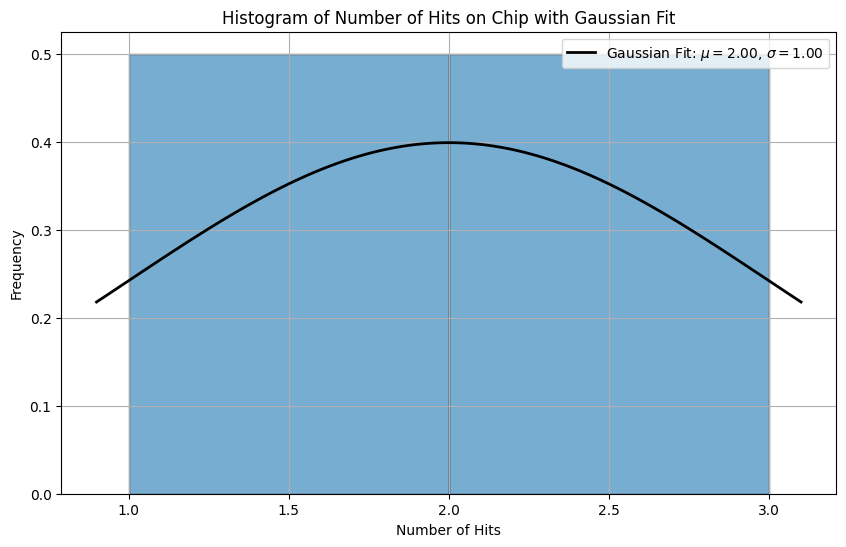

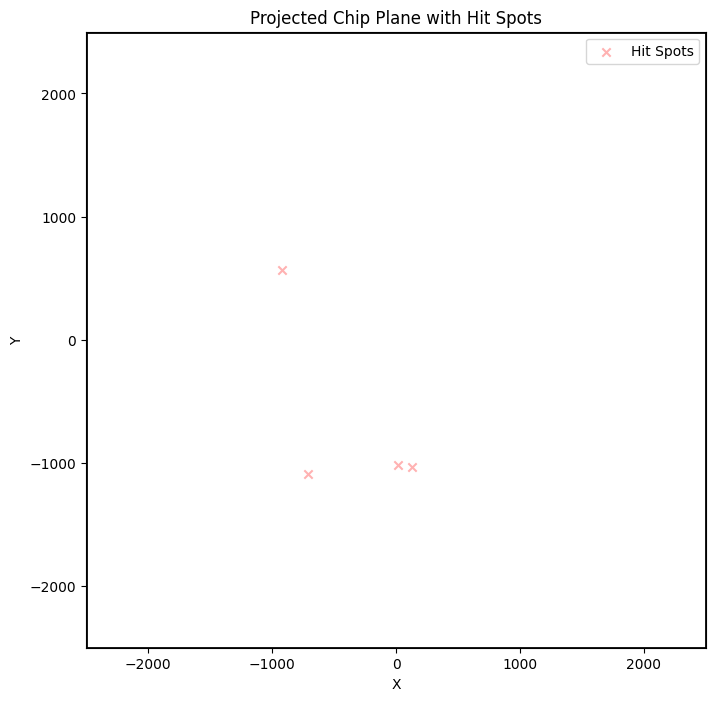

In [5]:
num_experiments = 2    # number of repetitions
num_particles = 2000   # number of particles emitted for one repetition

############################### Simulation Part #########################################

all_hit_positions = []
hit_counts = []

for _ in range(num_experiments):
    x_paths, y_paths, z_paths = generate_paths(num_particles, circle_radius, source_z, cylinders, chip_z)

    hit_count, hit_positions = count_hits_on_chip(x_paths, y_paths, z_paths, chip_z, chip_plane_width, chip_plane_length)
    hit_counts.append(hit_count)
    all_hit_positions.extend(hit_positions)

plot_hist(hit_counts)
plot_chip_with_hits(all_hit_positions, chip_plane_width, chip_plane_length)

# 3) Define hit center and radius and get parameters for cylinder

In [3]:
############################### Parameters #########################################

center_x = 0          # x-coordinate for target center
center_y = 0          # y-coordinate for target center
radius = 200          # radius of target circle


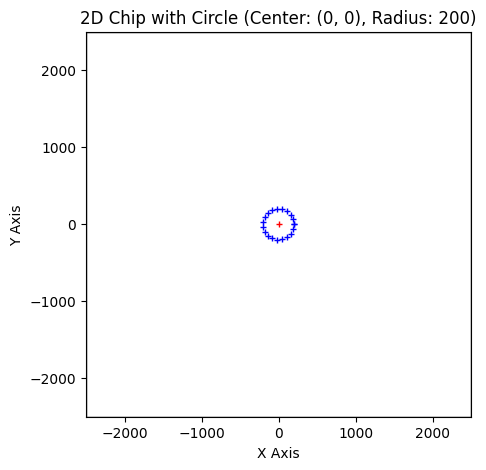

Coordinates of center point of lower circle: (np.float64(0.0), np.float64(0.0), 0)
Coordinates of center point of upper circle: (np.float64(0.0), np.float64(0.0), 13700)
Radius of the lower circle: 485.71428571428567
Radius of the upper circle: 224.7619047619047


In [8]:
############################### Simulation Part #########################################

boundary_pts = 20     # number of boundary points
num_particles = 1000  # number of particles emittedf from source

source_position = np.array([0, 0, source_z])
boundary_points = plot_2d_chip_with_circle(center_x, center_y, radius, chip_plane_width, chip_plane_length, chip_z, boundary_pts)

intersections_upper = []
intersections_lower = []

for boundary_point in boundary_points:
    intersection_upper, intersection_lower = find_intersection_with_planes(source_position, boundary_point, wall_upper, wall_lower)
    if intersection_upper is not None:
        intersections_upper.append(intersection_upper)
    if intersection_lower is not None:
        intersections_lower.append(intersection_lower)

center_xl, center_yl, center_zl, _, center_xu, center_yu, center_zu, _ = calculate_circle_properties(intersections_upper, intersections_lower)

radius_lower = diameter_at_z(wall_lower, source_z, chip_z, circle_radius, radius)/2
radius_upper = diameter_at_z(wall_upper, source_z, chip_z, circle_radius, radius)/2

print("Radius of the lower circle:", radius_lower, end="\n")
print("Radius of the upper circle:", radius_upper)

## a) Visualize Setup

In [9]:
cylinders = [Cylinder(radius_lower, [center_xl, center_yl], radius_upper, [center_xu, center_yu], 'green', wall_lower, wall_upper)]
x_paths, y_paths, z_paths = generate_paths(num_particles, circle_radius, source_z, cylinders, chip_z)

fig = go.Figure()
plot_simulation(fig, x_paths, y_paths, z_paths, source_z, cylinders, wall_upper, wall_lower, chip_z, plane_size, chip_plane_width, chip_plane_length, circle_radius)
fig.show()

hit_count, _ = count_hits_on_chip(x_paths, y_paths, z_paths, chip_z, chip_plane_width, chip_plane_length)
print(f"Number of particles that hit the chip: {hit_count}")


Number of particles that hit the chip: 0


## b) Run simulation

In [33]:
############################### Parameters #########################################
num_experiments = 200
num_particles =250000

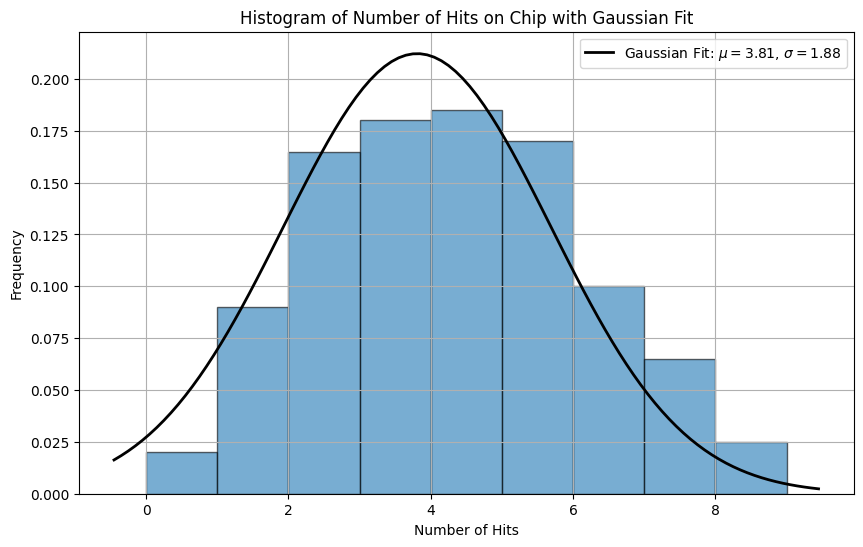

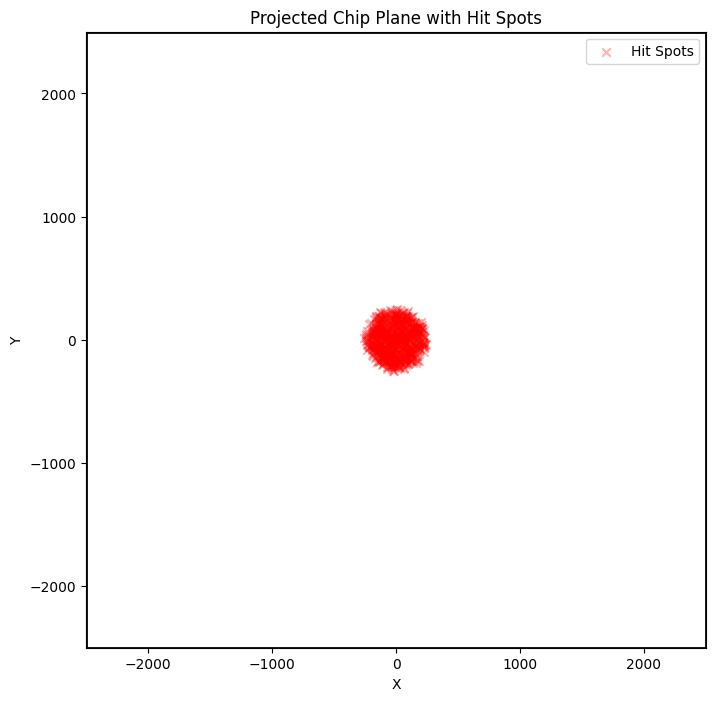

In [ ]:
############################### Simulation Part #########################################

all_hit_positions = []
hit_counts = []

for _ in range(num_experiments):
    x_paths, y_paths, z_paths = generate_paths(num_particles, circle_radius, source_z, cylinders, chip_z)

    hit_count, hit_positions = count_hits_on_chip(x_paths, y_paths, z_paths, chip_z, chip_plane_width, chip_plane_length)
    hit_counts.append(hit_count)
    all_hit_positions.extend(hit_positions)

plot_hist(hit_counts)
plot_chip_with_hits(all_hit_positions, chip_plane_width, chip_plane_length)


## Find optimal source position in z axis to get expected hit rate

############## Radius of hit circle: 65, Source_z: -27000.0 ################


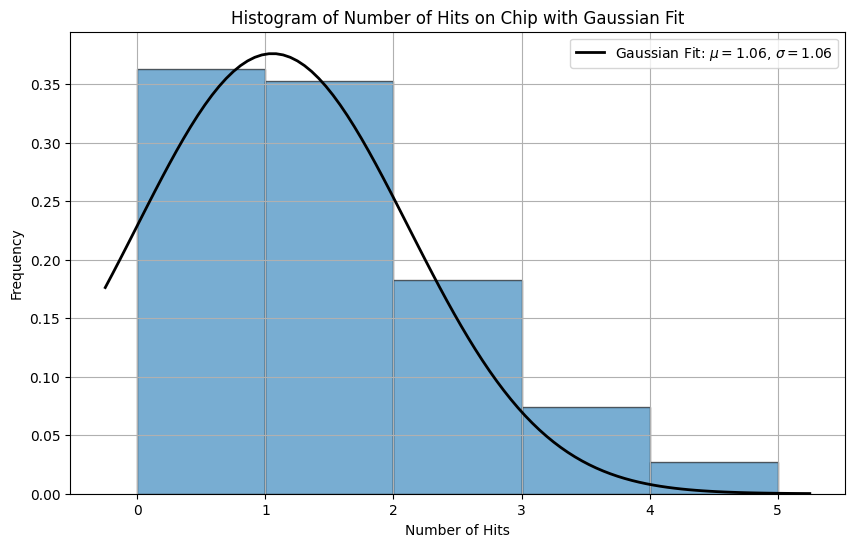

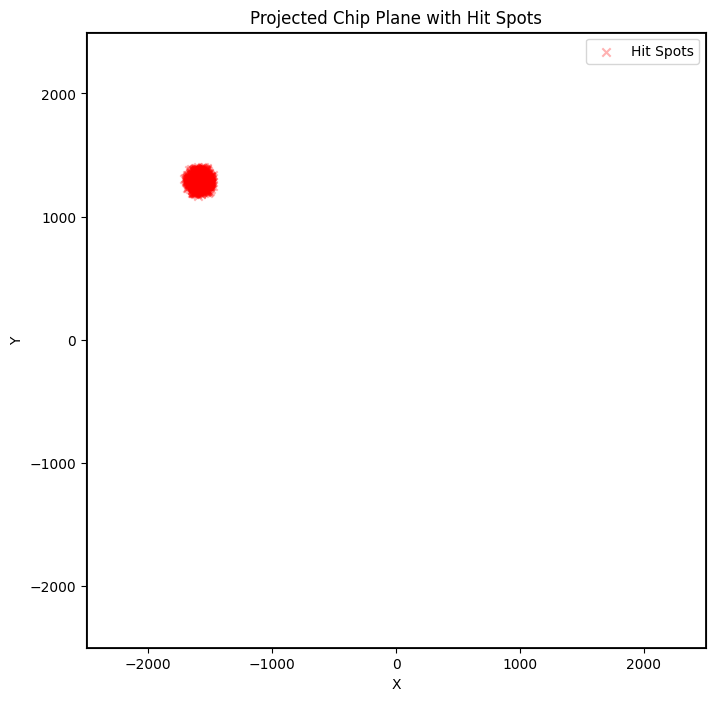



############## Radius of hit circle: 65, Source_z: -26000.0 ################


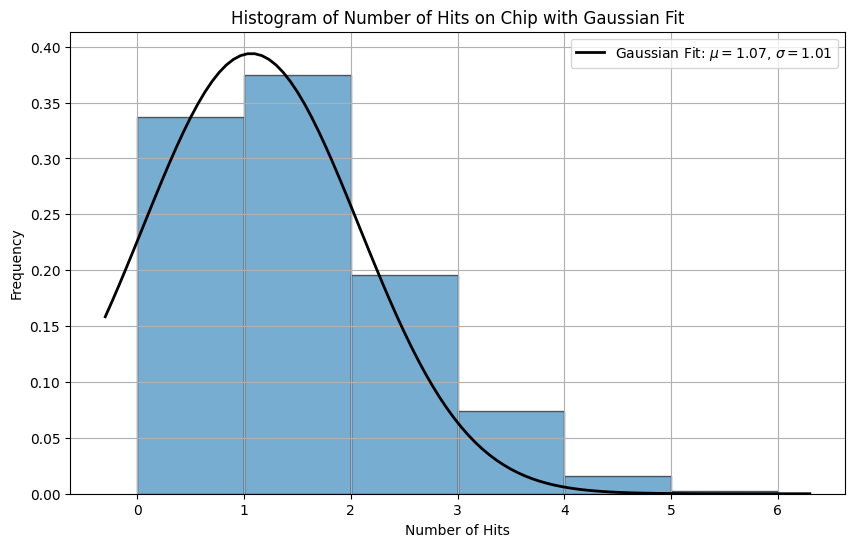

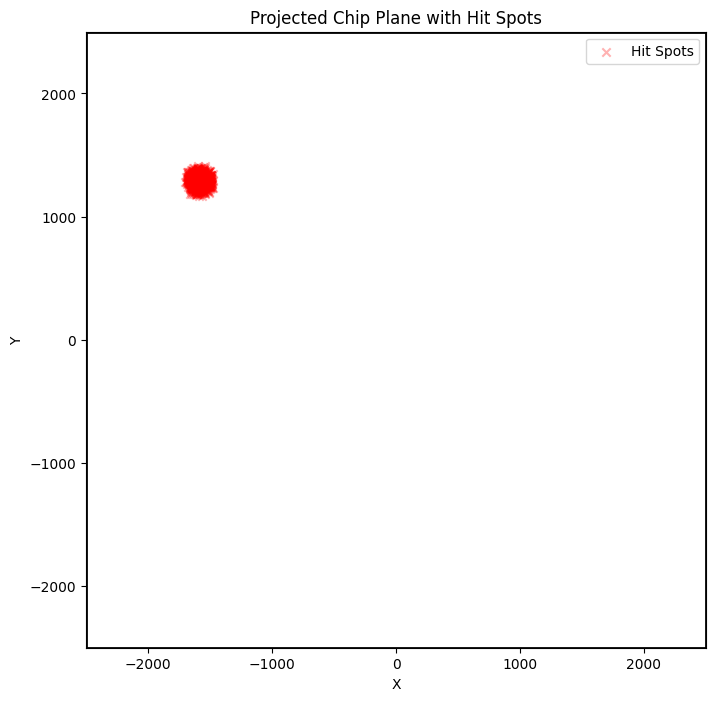



############## Radius of hit circle: 65, Source_z: -25000.0 ################


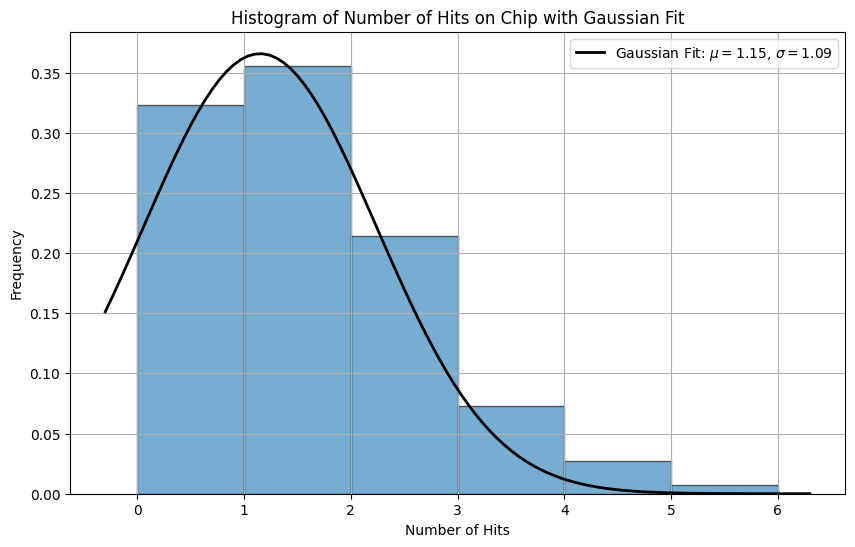

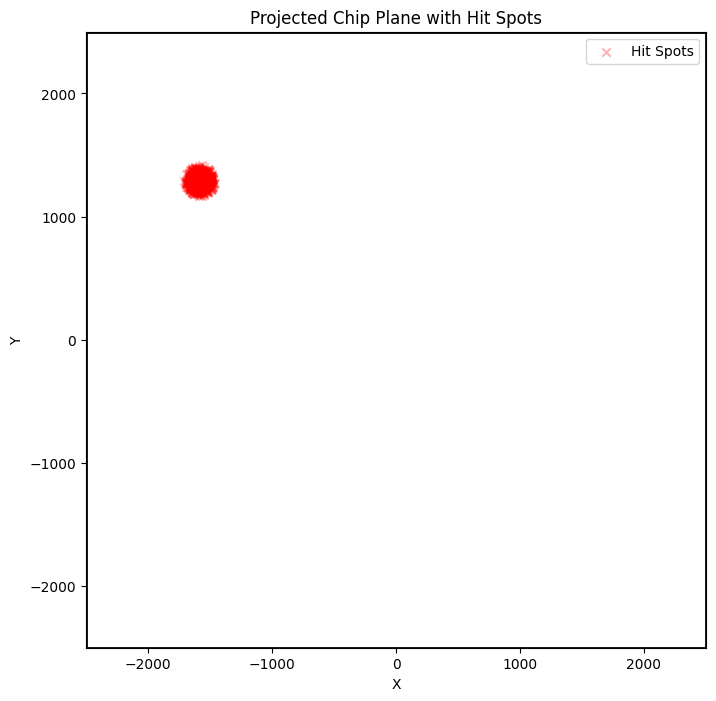

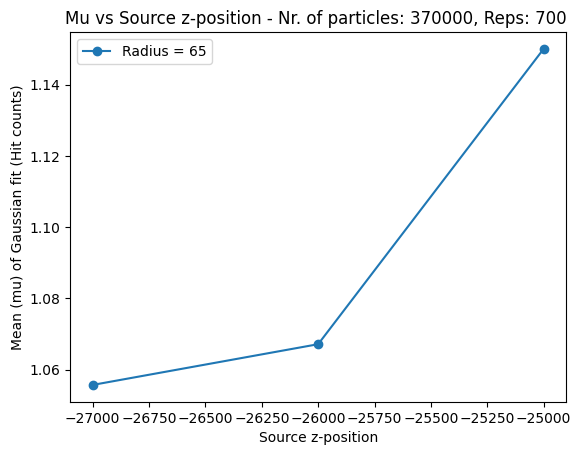

In [94]:
source_z_values = np.linspace(-27000, -25000, 3)   # sweep over source cap distance 
num_experiments = 700                              # number of repetitions
num_particles = 370000                             # number of emitted particles for each repetition
radius_values = [65, 80]                           # radius of hit/target circle at chip

mu_values = np.zeros((len(source_z_values), len(radius_values)))  
for radius_idx, radius in enumerate(radius_values):
    for source_z_idx, source_z in enumerate(source_z_values):
        
        source_position = [0, 0, source_z]  
        intersections_upper = []
        intersections_lower = []

        boundary_points = plot_2d_chip_with_circle(center_x, center_y, radius, chip_plane_width, chip_plane_length, chip_z, boundary_pts, show_plot=False)
        
        for boundary_point in boundary_points:
            intersection_upper, intersection_lower = find_intersection_with_planes(source_position, boundary_point, wall_upper, wall_lower)
            if intersection_upper is not None:
                intersections_upper.append(intersection_upper)
            if intersection_lower is not None:
                intersections_lower.append(intersection_lower)

        center_xl, center_yl, _, _, center_xu, center_yu, _, _ = calculate_circle_properties(intersections_upper, intersections_lower, print_output=False)
        radius_lower = diameter_at_z(wall_lower, source_z, chip_z, circle_radius, radius) / 2
        radius_upper = diameter_at_z(wall_upper, source_z, chip_z, circle_radius, radius) / 2
        cylinders = [Cylinder(radius_lower, [center_xl, center_yl], radius_upper, [center_xu, center_yu], 'green', wall_lower, wall_upper)]

        hit_counts = []
        hit_positions = []

        for _ in range(num_experiments):
            x_paths, y_paths, z_paths = generate_paths(num_particles, circle_radius, source_z, cylinders, chip_z)
            hit_count, hit_position = count_hits_on_chip(x_paths, y_paths, z_paths, chip_z, chip_plane_width, chip_plane_length)
            hit_counts.append(hit_count)
            hit_positions.extend(hit_position)

        mu, std = norm.fit(hit_counts)
        mu_values[source_z_idx, radius_idx] = mu
        
        print(f"############## Radius of hit circle: {radius}, Source_z: {source_z} ################")
        plot_hist(hit_counts)
        plot_chip_with_hits(hit_positions, chip_plane_width, chip_plane_length)
        print(end="\n\n")

plt.figure()
for radius_idx, radius in enumerate(radius_values):
    plt.plot(source_z_values, mu_values[:, radius_idx], '-o', label=f'Radius = {radius}')

plt.xlabel("Source z-position")
plt.ylabel("Mean (mu) of Gaussian fit (Hit counts)")
plt.title(f"Mu vs Source z-position - Nr. of particles: {num_particles}, Reps: {num_experiments} ")
plt.legend()
plt.show()
